## target_class별로 CAGR의 평균의 차이 검정 
-> ANOVA로 확인시 그룹간 CAGR 평균의 차이가 있음 

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings


In [15]:
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

2022년도 데이터 (df2) 상위 5개 행:
          회사명    거래소코드  회계년도  이자보상배율(이자비용)  영업활동으로 인한 현금흐름(*)(천원)  \
9     동화약품(주)  000020   2022         80.85               29220767   
19  케이알모터스(주)  000040   2022         -0.82               -2410237   
29      (주)경방  000050   2022          4.50               29255425   
39   (주)삼양홀딩스  000070   2022          3.92               95653804   
49   하이트진로(주)  000080   2022          4.94              -74014170   

    투자활동으로 인한 현금흐름(*)(천원)  재무활동으로 인한 현금흐름(*)(천원)    당좌비율  정상영업이익증가율  순이익증가율  \
9               -43272030              -12013033  239.20      32.98   14.06   
19               -6815671                1705983   37.74    -308.08 -458.92   
29              -16134056               -7053903   34.71     -40.71  -80.19   
39             -123729616               85468446  161.23     -62.38  -70.13   
49                5958539             -116457464   53.88       9.45   21.27   

    ...   EBITDA(천원)        x3        x4        roe        pcr         psr  \
9   ..

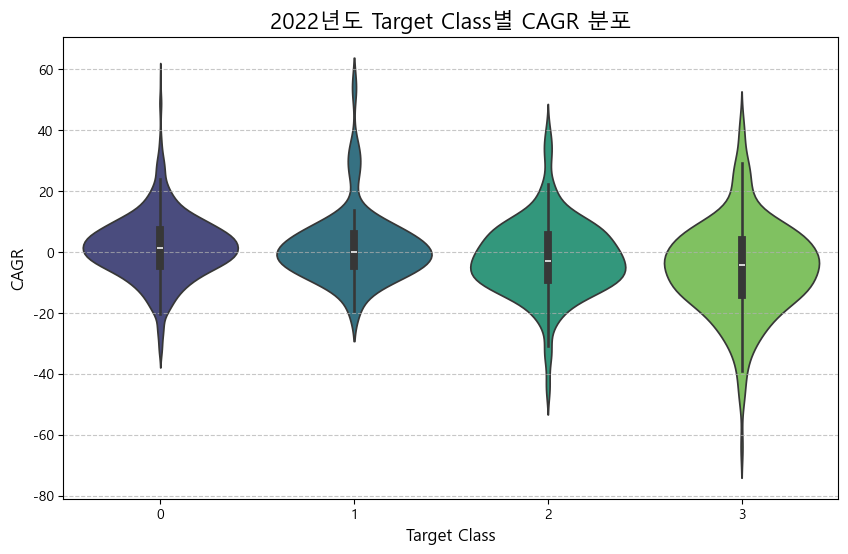


--- ANOVA 검정 결과 ---
F-statistic: 28.1851
P-value: 0.0000

P-value (0.0000)는 유의수준 0.05보다 작으므로,
귀무가설을 기각합니다. 즉, 'target_class' 그룹별 CAGR 평균에는 통계적으로 유의미한 차이가 있습니다.
이제 어떤 그룹 간에 차이가 나는지 사후분석(Tukey HSD)을 통해 확인합니다.

--- Tukey HSD 사후 분석 결과 ---
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1   0.0017    1.0  -3.6007  3.6042  False
     0      2  -3.7621    0.0  -5.8262  -1.698   True
     0      3  -6.9453    0.0  -9.0491 -4.8415   True
     1      2  -3.7638 0.0717   -7.745  0.2173  False
     1      3   -6.947 0.0001 -10.9489 -2.9451   True
     2      3  -3.1832 0.0132  -5.8846 -0.4817   True
-----------------------------------------------------

사후분석 결과 해석:
 - 'p-adj' 컬럼을 확인하세요.
 - 'p-adj' 값이 {alpha}보다 작으면 해당 두 그룹의 평균 CAGR은 통계적으로 유의미한 차이가 있습니다.
 - 'reject' 컬럼이 True이면 귀무가설(두 그룹 평균이 같다)을 기각하고 대립가설(두 그룹 평균이 다르다)을 채택합니다.

--- 분석 완료 ---


In [17]:
# 1. 데이터 불러오기 
df = pd.read_excel('이거진짜마지막데이터셋.copy.xlsx', dtype={'거래소코드': str})

# 2. 2022년 데이터 필터링 (이 부분도 이미 하셨다고 가정합니다)
df2 = df[df['회계년도'] == 2022].copy() # .copy()를 추가하여 SettingWithCopyWarning 방지

print("2022년도 데이터 (df2) 상위 5개 행:")
print(df2.head())
print(f"\n2022년도 데이터 (df2) 개수: {len(df2)}개")

# 3. 필요한 컬럼 존재 여부 확인 및 결측치 처리 (중요!)
required_columns = ['target_class', 'CAGR']
if not all(col in df2.columns for col in required_columns):
    print(f"\n오류: 2022년도 데이터에 다음 필수 컬럼 중 하나 이상이 없습니다: {required_columns}")
    print("데이터프레임 컬럼:", df2.columns.tolist())
    exit()

# 'target_class'와 'CAGR'에 결측치가 있는 행 제거
original_df2_rows = len(df2)
df2.dropna(subset=['target_class', 'CAGR'], inplace=True)
if len(df2) < original_df2_rows:
    print(f"\n주의: df2에서 'target_class' 또는 'CAGR'에 결측치가 있는 {original_df2_rows - len(df2)}개의 행이 제거되었습니다.")
    if len(df2) == 0:
        print("경고: 2022년 데이터 중 분석에 사용할 수 있는 데이터가 없습니다. 스크립트를 종료합니다.")
        exit()

# 'target_class'의 고유값과 각 값의 개수 확인
print("\n'target_class' 고유값 및 개수:")
print(df2['target_class'].value_counts())

# 각 target_class 그룹별 데이터 수가 너무 적은 경우 (사후분석에 문제될 수 있음)
# 예를 들어, 한 그룹에 1개 데이터만 있으면 분산을 계산할 수 없어 오류 발생 가능.
# 최소 2개 이상의 데이터가 있는 그룹만 ANOVA 및 사후분석에 포함하는 것이 일반적.
# statsmodels.pairwise_tukeyhsd는 이런 경우를 비교에서 제외하거나 에러를 발생시킬 수 있음.
min_obs_per_group = df2['target_class'].value_counts().min()
if min_obs_per_group < 2:
    print(f"\n경고: 일부 'target_class' 그룹의 데이터 수가 2개 미만입니다 (최소: {min_obs_per_group}개).")
    print("이 경우 ANOVA 또는 사후분석 결과가 불안정하거나 오류가 발생할 수 있습니다.")
    print("해당 그룹을 제외하거나 더 많은 데이터를 확보하는 것을 고려해주세요.")


# 4. 'target_class' 그룹별 CAGR 평균 계산
cagr_means_by_class = df2.groupby('target_class')['CAGR'].mean()
print("\n2022년도 'target_class' 그룹별 CAGR 평균:")
print(cagr_means_by_class)

# 5. Violin Plot 시각화
plt.figure(figsize=(10, 6))
sns.violinplot(x='target_class', y='CAGR', data=df2, palette='viridis')
plt.title('2022년도 Target Class별 CAGR 분포', fontsize=16)
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('CAGR', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 6. ANOVA 검정
print("\n--- ANOVA 검정 결과 ---")

# ANOVA를 위해 각 target_class 그룹의 CAGR 데이터를 추출
groups = []
unique_classes = df2['target_class'].dropna().unique()
unique_classes.sort() # 순서대로 정렬 (선택 사항이지만 결과의 일관성을 위해)

if len(unique_classes) < 2:
    print(f"\nANOVA를 수행할 수 없습니다. 2022년도 데이터에 {len(unique_classes)}개 미만의 'target_class' 그룹이 있습니다.")
else:
    for cls in unique_classes:
        group_data = df2[df2['target_class'] == cls]['CAGR'].dropna()
        if not group_data.empty:
            groups.append(group_data)
        else:
            print(f"경고: 'target_class' {cls} 그룹에 2022년도 CAGR 데이터가 없거나 모두 결측치입니다. ANOVA에서 제외됩니다.")

    if len(groups) < 2:
        print("\nANOVA를 수행할 수 없습니다. 최소 2개 이상의 그룹에 데이터가 있어야 합니다.")
    elif any(len(g) == 0 for g in groups):
        print("\nANOVA를 수행할 수 없습니다. 하나 이상의 그룹에 데이터가 없습니다.")
    else:
        f_statistic, p_value = stats.f_oneway(*groups)

        print(f"F-statistic: {f_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")

        alpha = 0.05 # 유의수준
        if p_value < alpha:
            print(f"\nP-value ({p_value:.4f})는 유의수준 {alpha}보다 작으므로,")
            print("귀무가설을 기각합니다. 즉, 'target_class' 그룹별 CAGR 평균에는 통계적으로 유의미한 차이가 있습니다.")
            print("이제 어떤 그룹 간에 차이가 나는지 사후분석(Tukey HSD)을 통해 확인합니다.")

            # 7. 사후분석 (Tukey HSD)
            # ANOVA 결과가 유의미할 때만 사후분석을 수행하는 것이 일반적입니다.
            try:
                # pairwise_tukeyhsd 함수는 원본 데이터프레임의 컬럼을 직접 사용합니다.
                # endog: 종속 변수 (CAGR)
                # groups: 그룹 변수 (target_class)
                # alpha: 유의수준
                tukey_result = pairwise_tukeyhsd(endog=df2['CAGR'],
                                                 groups=df2['target_class'],
                                                 alpha=alpha)
                print("\n--- Tukey HSD 사후 분석 결과 ---")
                print(tukey_result)

                # 사후분석 결과 해석:
                print("\n사후분석 결과 해석:")
                print(" - 'p-adj' 컬럼을 확인하세요.")
                print(" - 'p-adj' 값이 {alpha}보다 작으면 해당 두 그룹의 평균 CAGR은 통계적으로 유의미한 차이가 있습니다.")
                print(" - 'reject' 컬럼이 True이면 귀무가설(두 그룹 평균이 같다)을 기각하고 대립가설(두 그룹 평균이 다르다)을 채택합니다.")

            except Exception as e:
                print(f"\n사후분석 중 오류가 발생했습니다: {e}")
                print("일부 그룹의 데이터 수가 너무 적거나, 분산을 계산할 수 없을 때 발생할 수 있습니다.")

        else:
            print(f"\nP-value ({p_value:.4f})는 유의수준 {alpha}보다 크거나 같으므로,")
            print("귀무가설을 기각할 수 없습니다. 즉, 'target_class' 그룹별 CAGR 평균에는 통계적으로 유의미한 차이가 있다고 보기 어렵습니다.")
            print("따라서 사후분석을 진행할 필요가 없습니다.")

print("\n--- 분석 완료 ---")

## target_class별로 연간변동성의 평균의 차이 검정 
-> ANOVA로 확인시 그룹간 연간변동성의 평균의 차이가 있음 

2022년도 데이터 (df2) 상위 5개 행:
          회사명    거래소코드  회계년도  이자보상배율(이자비용)  영업활동으로 인한 현금흐름(*)(천원)  \
9     동화약품(주)  000020   2022         80.85               29220767   
19  케이알모터스(주)  000040   2022         -0.82               -2410237   
29      (주)경방  000050   2022          4.50               29255425   
39   (주)삼양홀딩스  000070   2022          3.92               95653804   
49   하이트진로(주)  000080   2022          4.94              -74014170   

    투자활동으로 인한 현금흐름(*)(천원)  재무활동으로 인한 현금흐름(*)(천원)    당좌비율  정상영업이익증가율  순이익증가율  \
9               -43272030              -12013033  239.20      32.98   14.06   
19               -6815671                1705983   37.74    -308.08 -458.92   
29              -16134056               -7053903   34.71     -40.71  -80.19   
39             -123729616               85468446  161.23     -62.38  -70.13   
49                5958539             -116457464   53.88       9.45   21.27   

    ...   EBITDA(천원)        x3        x4        roe        pcr         psr  \
9   ..

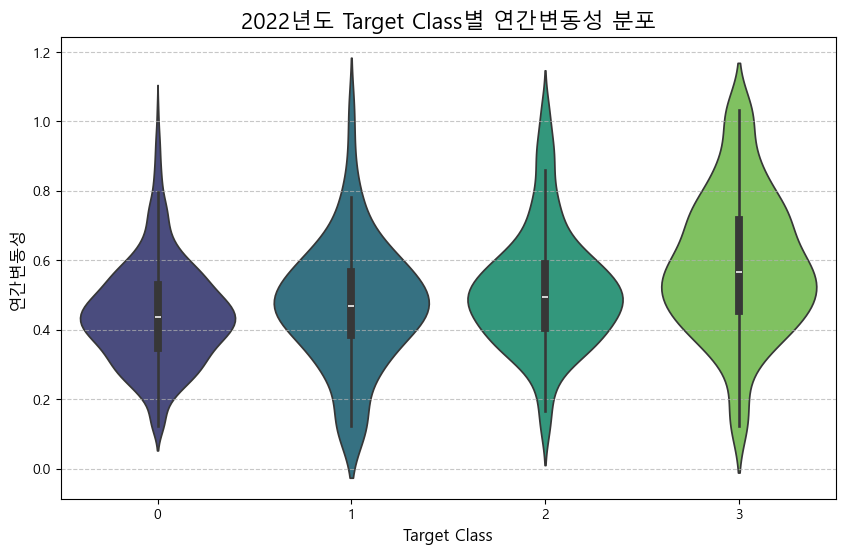


--- 연간변동성 ANOVA 검정 결과 ---
F-statistic: 56.4356
P-value: 0.0000

P-value (0.0000)는 유의수준 0.05보다 작으므로,
귀무가설을 기각합니다. 즉, 'target_class' 그룹별 연간변동성 평균에는 통계적으로 유의미한 차이가 있습니다.
이제 어떤 그룹 간에 차이가 나는지 사후분석(Tukey HSD)을 통해 확인합니다.

--- 연간변동성 Tukey HSD 사후 분석 결과 ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0254  0.554 -0.0243 0.0751  False
     0      2    0.067    0.0  0.0385 0.0955   True
     0      3   0.1392    0.0  0.1102 0.1682   True
     1      2   0.0416 0.2079 -0.0133 0.0965  False
     1      3   0.1138    0.0  0.0586  0.169   True
     2      3   0.0722    0.0  0.0349 0.1094   True
---------------------------------------------------

사후분석 결과 해석:
 - 'p-adj' 컬럼을 확인하세요.
 - 'p-adj' 값이 {alpha}보다 작으면 해당 두 그룹의 평균 연간변동성은 통계적으로 유의미한 차이가 있습니다.
 - 'reject' 컬럼이 True이면 귀무가설(두 그룹 평균이 같다)을 기각하고 대립가설(두 그룹 평균이 다르다)을 채택합니다.

--- 연간변동성 분석 완료 ---


In [18]:
# 1. 데이터 불러오기
df = pd.read_excel('이거진짜마지막데이터셋.copy.xlsx', dtype={'거래소코드': str})

# 2. 2022년 데이터 필터링
df2 = df[df['회계년도'] == 2022].copy() # .copy()를 추가하여 SettingWithCopyWarning 방지

print("2022년도 데이터 (df2) 상위 5개 행:")
print(df2.head())
print(f"\n2022년도 데이터 (df2) 개수: {len(df2)}개")

# 3. 필요한 컬럼 존재 여부 확인 및 결측치 처리 (중요!)
# '연간변동성' 컬럼이 필요합니다.
required_columns = ['target_class', '연간변동성']
if not all(col in df2.columns for col in required_columns):
    print(f"\n오류: 2022년도 데이터에 다음 필수 컬럼 중 하나 이상이 없습니다: {required_columns}")
    print("데이터프레임 컬럼:", df2.columns.tolist())
    exit()

# 'target_class'와 '연간변동성'에 결측치가 있는 행 제거
original_df2_rows = len(df2)
df2.dropna(subset=['target_class', '연간변동성'], inplace=True)
if len(df2) < original_df2_rows:
    print(f"\n주의: df2에서 'target_class' 또는 '연간변동성'에 결측치가 있는 {original_df2_rows - len(df2)}개의 행이 제거되었습니다.")
    if len(df2) == 0:
        print("경고: 2022년 데이터 중 분석에 사용할 수 있는 데이터가 없습니다. 스크립트를 종료합니다.")
        exit()

# 'target_class'의 고유값과 각 값의 개수 확인
print("\n'target_class' 고유값 및 개수:")
print(df2['target_class'].value_counts())

# 각 target_class 그룹별 데이터 수가 너무 적은 경우 (사후분석에 문제될 수 있음)
min_obs_per_group = df2['target_class'].value_counts().min()
if min_obs_per_group < 2:
    print(f"\n경고: 일부 'target_class' 그룹의 데이터 수가 2개 미만입니다 (최소: {min_obs_per_group}개).")
    print("이 경우 ANOVA 또는 사후분석 결과가 불안정하거나 오류가 발생할 수 있습니다.")
    print("해당 그룹을 제외하거나 더 많은 데이터를 확보하는 것을 고려해주세요.")


# 4. 'target_class' 그룹별 연간변동성 평균 계산
volatility_means_by_class = df2.groupby('target_class')['연간변동성'].mean()
print("\n2022년도 'target_class' 그룹별 연간변동성 평균:")
print(volatility_means_by_class)

# 5. Violin Plot 시각화
plt.figure(figsize=(10, 6))
sns.violinplot(x='target_class', y='연간변동성', data=df2, palette='viridis')
plt.title('2022년도 Target Class별 연간변동성 분포', fontsize=16)
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('연간변동성', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 6. ANOVA 검정
print("\n--- 연간변동성 ANOVA 검정 결과 ---")

# ANOVA를 위해 각 target_class 그룹의 연간변동성 데이터를 추출
groups_volatility = []
unique_classes_volatility = df2['target_class'].dropna().unique()
unique_classes_volatility.sort() # 순서대로 정렬 (선택 사항이지만 결과의 일관성을 위해)

if len(unique_classes_volatility) < 2:
    print(f"\nANOVA를 수행할 수 없습니다. 2022년도 데이터에 {len(unique_classes_volatility)}개 미만의 'target_class' 그룹이 있습니다.")
else:
    for cls in unique_classes_volatility:
        group_data_volatility = df2[df2['target_class'] == cls]['연간변동성'].dropna()
        if not group_data_volatility.empty:
            groups_volatility.append(group_data_volatility)
        else:
            print(f"경고: 'target_class' {cls} 그룹에 2022년도 연간변동성 데이터가 없거나 모두 결측치입니다. ANOVA에서 제외됩니다.")

    if len(groups_volatility) < 2:
        print("\nANOVA를 수행할 수 없습니다. 최소 2개 이상의 그룹에 데이터가 있어야 합니다.")
    elif any(len(g) == 0 for g in groups_volatility):
        print("\nANOVA를 수행할 수 없습니다. 하나 이상의 그룹에 데이터가 없습니다.")
    else:
        f_statistic_volatility, p_value_volatility = stats.f_oneway(*groups_volatility)

        print(f"F-statistic: {f_statistic_volatility:.4f}")
        print(f"P-value: {p_value_volatility:.4f}")

        alpha = 0.05 # 유의수준
        if p_value_volatility < alpha:
            print(f"\nP-value ({p_value_volatility:.4f})는 유의수준 {alpha}보다 작으므로,")
            print("귀무가설을 기각합니다. 즉, 'target_class' 그룹별 연간변동성 평균에는 통계적으로 유의미한 차이가 있습니다.")
            print("이제 어떤 그룹 간에 차이가 나는지 사후분석(Tukey HSD)을 통해 확인합니다.")

            # 7. 사후분석 (Tukey HSD)
            try:
                tukey_result_volatility = pairwise_tukeyhsd(endog=df2['연간변동성'],
                                                             groups=df2['target_class'],
                                                             alpha=alpha)
                print("\n--- 연간변동성 Tukey HSD 사후 분석 결과 ---")
                print(tukey_result_volatility)

                # 사후분석 결과 해석:
                print("\n사후분석 결과 해석:")
                print(" - 'p-adj' 컬럼을 확인하세요.")
                print(" - 'p-adj' 값이 {alpha}보다 작으면 해당 두 그룹의 평균 연간변동성은 통계적으로 유의미한 차이가 있습니다.")
                print(" - 'reject' 컬럼이 True이면 귀무가설(두 그룹 평균이 같다)을 기각하고 대립가설(두 그룹 평균이 다르다)을 채택합니다.")

            except Exception as e:
                print(f"\n사후분석 중 오류가 발생했습니다: {e}")
                print("일부 그룹의 데이터 수가 너무 적거나, 분산을 계산할 수 없을 때 발생할 수 있습니다.")

        else:
            print(f"\nP-value ({p_value_volatility:.4f})는 유의수준 {alpha}보다 크거나 같으므로,")
            print("귀무가설을 기각할 수 없습니다. 즉, 'target_class' 그룹별 연간변동성 평균에는 통계적으로 유의미한 차이가 있다고 보기 어렵습니다.")
            print("따라서 사후분석을 진행할 필요가 없습니다.")

print("\n--- 연간변동성 분석 완료 ---")